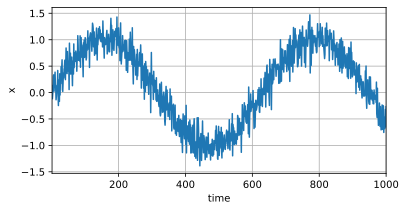

In [1]:
# 处理序列数据需要统计工具和新的深度神经网络架构。
# 首先，我们生成一些数据：使用正弦函数和一些可加性噪声来生成序列数据， 时间步为1,2,...1000

%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [2]:
# 我要把这一组数据，变成 train_iter，其中 tau 是我根据前面几个来推断下一个的数字(我根据前tau个数字，判断我下一个数字是多少)

tau = 4
features = torch.zeros((T-tau, tau)) # 我虽然是按列存，但是从行的角度，就是tau一行的顺序数列
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1)) # 把答案也reshape成一列，方便对应，这样labels[0] = features[0, :]的预测值

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [3]:
# 在这里，我们使用一个相当简单的架构训练模型： 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction = 'none') # reduction = none 表示每个样本的损失都会返回一个标量

In [4]:
def train(net, train_iter, loss, num_epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.060637
epoch 2, loss: 0.055558
epoch 3, loss: 0.055782
epoch 4, loss: 0.051582
epoch 5, loss: 0.050552
epoch 6, loss: 0.049779
epoch 7, loss: 0.053467
epoch 8, loss: 0.048769
epoch 9, loss: 0.050463
epoch 10, loss: 0.051526


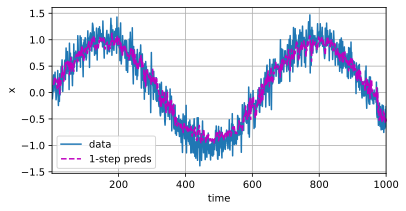

In [5]:
# 由于训练损失很小，因此我们期望模型能有很好的工作效果。 让我们看看这在实践中意味着什么。 
# 首先是检查模型预测下一个时间步的能力， 也就是单步预测（one-step-ahead prediction）。

onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

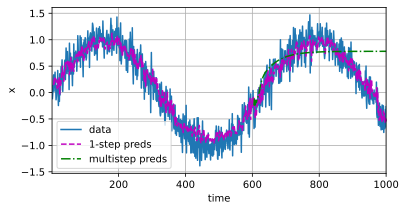

In [6]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

In [7]:
# 如上面的例子所示，绿线的预测显然并不理想。 经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。 
# 为什么这个算法效果这么差呢？事实是由于错误的累积
# 基于k = 1,4,16,64，通过对整个序列预测的计算， 让我们更仔细地看一下k步预测的困难。

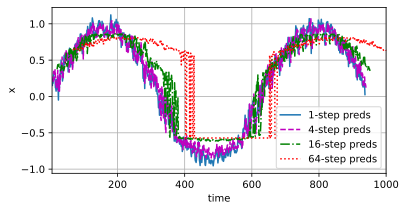

In [8]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))